##1. Bridge와 Overlap

^C
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


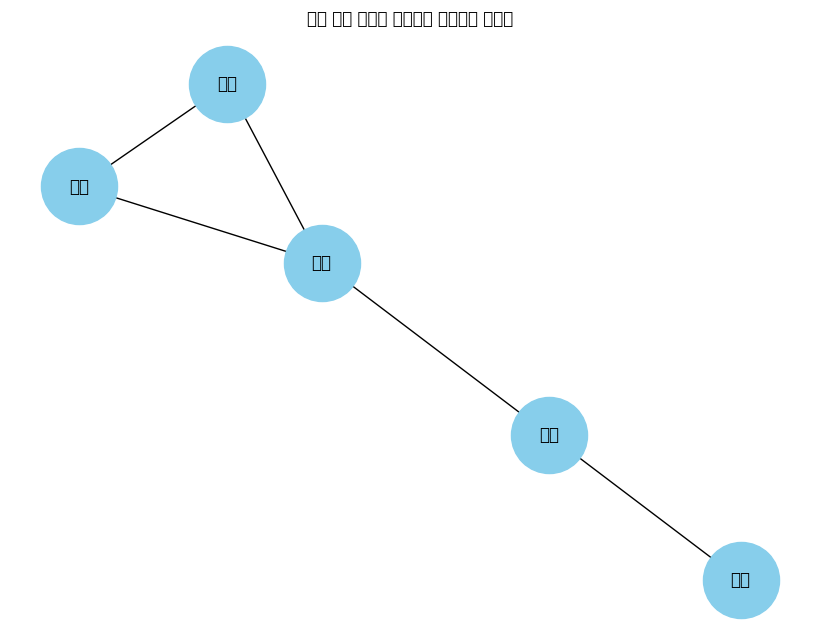

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import networkx as nx

# 코랩에 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 나눔고딕 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)
plt.rc('font', family=fontprop.get_name())

# 그래프 생성
G = nx.Graph()

# 노드 추가 (한글 지역 이름 사용)
nodes = ["서울", "강릉", "파주", "부산", "대구"]
G.add_nodes_from(nodes)

# 엣지 추가
edges = [("서울", "강릉"), ("서울", "파주"), ("서울", "부산"), ("부산", "대구"), ("강릉", "파주")]
G.add_edges_from(edges)

# 그래프 그리기
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_family=fontprop.get_name(), font_size=12, node_size=3000, node_color='skyblue', font_color='black')
plt.title("한글 노드 이름을 사용하는 네트워크 그래프")
plt.show()


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- 예제 데이터 읽기: Game of Thrones edge data

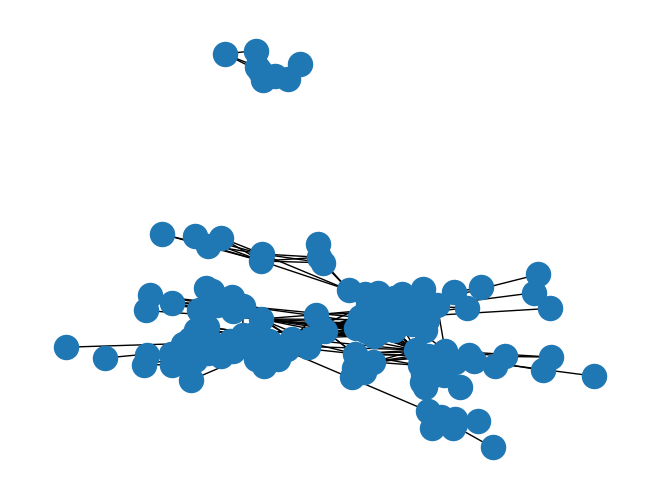

In [ ]:
g = nx.Graph()
data = pd.read_csv("got-s6-edges.csv")

for i in np.arange(data.shape[0]):
   g.add_edge(data.iloc[i, 0], data.iloc[i, 1], weight=int(data.iloc[i, 2]))

nx.draw(g)

- Bridges and Local Bridges
 - local bridge: edge의 노드들이 더 이상 Common neighborhood가 없는 경우를 의미

 - bridge 체크

In [ ]:
nx.has_bridges(g)    # 브릿지가 있냐? 없냐?

True

 - 모든 bridge 확인

In [ ]:
list(nx.bridges(g))

[('JON', 'SAM'),
 ('JON', 'JEOR'),
 ('MISSANDEI', 'KRAZNYS_MO_NAKLOZ'),
 ('TYRION', 'AERYS'),
 ('DAVOS', 'SHIREEN'),
 ('SAM', 'MAESTER_AEMON'),
 ('CERSEI', 'MOUNTAIN'),
 ('TORMUND', 'MANCE'),
 ('HOUND', 'GATINS'),
 ('BRYNDEN', 'MINISA'),
 ('EDMURE', 'HOSTER'),
 ('QYBURN', 'ARTHUR_CHILD'),
 ('NED', 'RICKARD_STARK')]

 - local bridges와 span 계산: Span은 local bridge의 연결된 두 노드 사이에서, 해당 연결이 제거될 때의 shortest path length

In [ ]:
list(nx.local_bridges(g, with_span=True))

[('JON', 'SAM', inf),
 ('JON', 'JEOR', inf),
 ('MISSANDEI', 'KRAZNYS_MO_NAKLOZ', inf),
 ('TYRION', 'AERYS', inf),
 ('VARYS', 'STANNIS', 3),
 ('ARYA', 'WALDER', 3),
 ('DAVOS', 'SHIREEN', inf),
 ('SAM', 'MAESTER_AEMON', inf),
 ('CERSEI', 'MOUNTAIN', inf),
 ('TORMUND', 'MANCE', inf),
 ('HOUND', 'GATINS', inf),
 ('BRYNDEN', 'MINISA', inf),
 ('EDMURE', 'HOSTER', inf),
 ('QYBURN', 'ARTHUR_CHILD', inf),
 ('NED', 'RICKARD_STARK', inf)]

- Tie Strength

 - 모든 노드의 pair에서 오버랩을 통한 Tie Strength측정

In [ ]:
def node_overlap(g):
    for u, v in g.edges():
        n_u = set(g.neighbors(u)) # set of u neighbors
        n_v = set(g.neighbors(v)) # set of v neighbors
        overlap = len(n_u & n_v) / len(n_u | n_v) # Neighborhood Overlap
        g[u][v]['overlap'] = overlap
    return g

In [ ]:
g = node_overlap(g)

- Neighborhood Overlap의 분포를 그리기

In [ ]:
g.edges(data=True)

In [ ]:
weights = [ e[-1]['overlap'] for e in g.edges(data=True) ]
weights

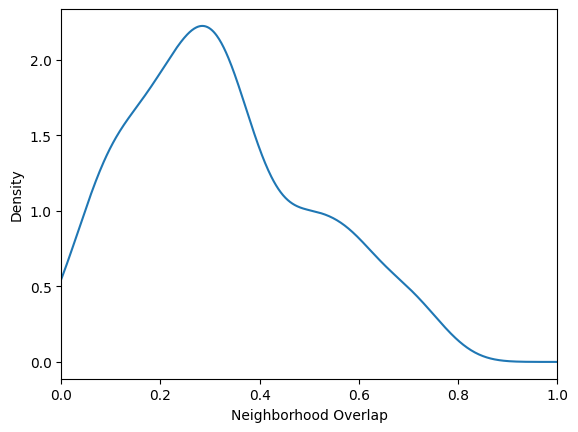

In [ ]:
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Neighborhood Overlap")
plt.xlim(0,1)
plt.show()

##2. Network Resilience
- Random and Scale-free Network
- Reslience for both Networks (molloy_reed  활용)
- 그래프 복원력을 Plot:Random Failure, Targeted Attacks

- 랜덤 네트워크: 노드의 Degree가 포아송 분포를 따르게 됨.
- Scale Free 네트워크: Power Law 분포, Hub가 존재하고 Degree가 높기 때문에 상당히 많은 노드들과 연결



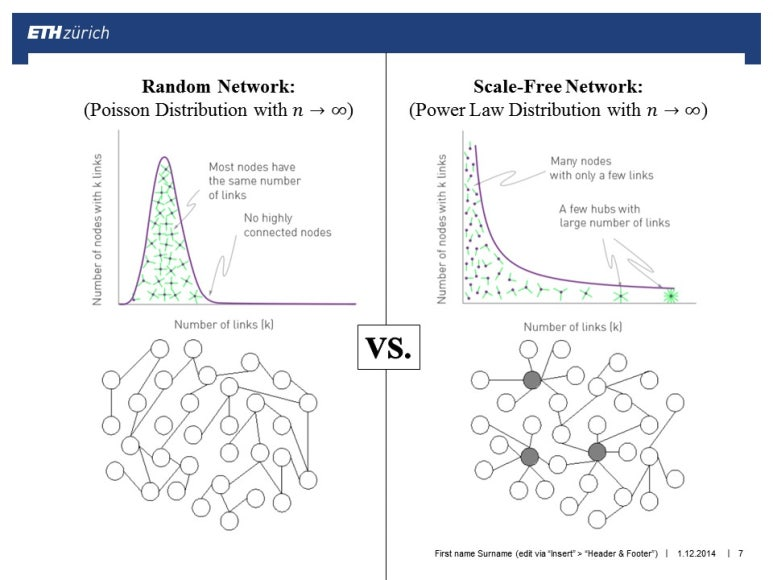

In [ ]:
# Random
er = nx.erdos_renyi_graph(1000, 0.001)
# Scale-free
ba = nx.barabasi_albert_graph(1000, 2)

-각 그래프에 대한 노드 Degree 계산

In [ ]:
er_degs = list(dict(er.degree()).values())
ba_degs = list(dict(ba.degree()).values())

- 네트워크 Resilience를 위해 Molloy-Reed threshold를 계산

In [ ]:
def molloy_reed(degrees):
    return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)

def breakdown_threshold(degrees):
    K = molloy_reed(degrees)
    return 1 - (1/(K-1))

- Random network

In [ ]:
molloy_reed(er_degs)

2.122

In [ ]:
breakdown_threshold(er_degs)

0.10873440285204983

- Scale-free network

In [ ]:
molloy_reed(ba_degs)

4.992

In [ ]:
breakdown_threshold(ba_degs)

0.7494989979959921

##3. Game of Throne 그래프에서의 Resilience 계산
### Random Failures

In [ ]:
def random_node(g): # 노드 랜덤하게 선택
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args): # 그래프에서 개수를 점점 늘려가며 노드를 제거
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes()) > 1:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
        g_size = 0
        if len(comps)>0:
            g_size  = max([len(c)for c in comps])/total_nodes
        components.append(g_size)
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True): # 정렬
    nodes = score(g)
    if isinstance(nodes, dict):
        nodes = [(k, v) for k, v in nodes.items()]
    srt = sorted(nodes, key = lambda k: k[1], reverse = reverse)
    return [x[0] for x in srt]

def plot_dismantle(x, y):
    plt.plot(x, y)
    plt.xlabel("Removed Nodes")
    plt.ylabel("Giant Component size")
    plt.show()

- Random Failure:: 노드가 제거될 수록 Giant component 크기 감소

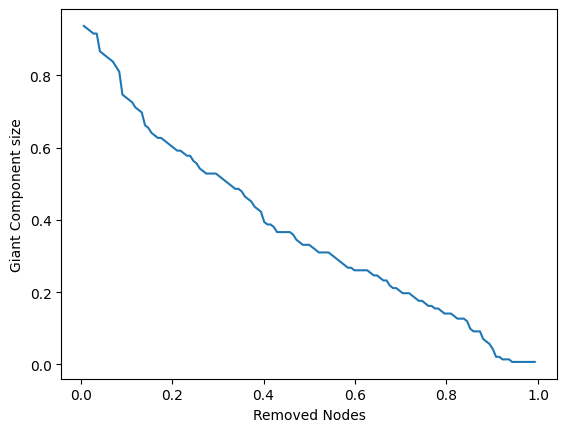

In [ ]:
h = g.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps)

### Targeted Attacks

- Targeted Node attack: 허브부터 제거
- Giant component 크기가 급격히 감소

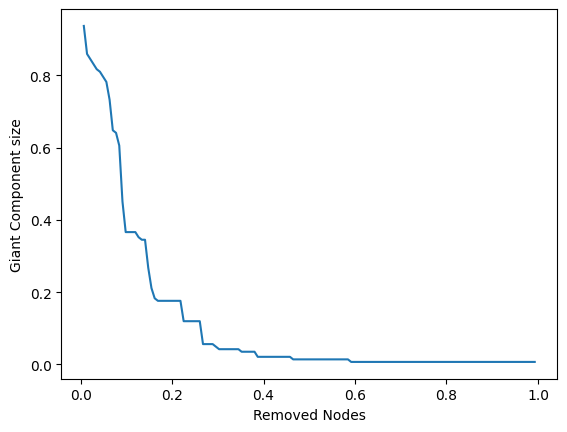

In [ ]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn, comps)

- Targeted Edge Attack: 주요 에지 제거 (based on Edge Betweenness Centrality)


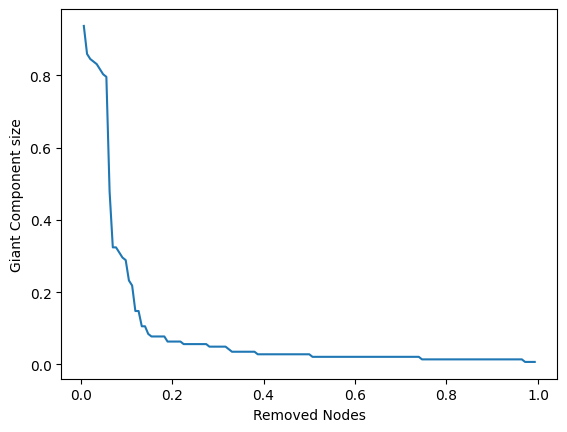

In [ ]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.betweenness_centrality)
plot_dismantle(rn, comps)